## LCPB 21-22 exercise 1 (Gradient descent & Deep Neural Networks, DNNs)

**Group 2310:** 
- Giovanni Zago 2089577
- Emanuele Sarte 2097419
- Alessio Saccomani 2090565
- Fateme Baghaei Saryazdi 2088827

### Request no. 1

We start the exercise by importing all the necessary modules, setting the seeds for reproducibility and some appearence settings.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.random as tf_r
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras
import numpy as np

np.random.seed(12345)
tf_r.set_seed(12345)

mpl.rc('image', cmap='copper')
plt.rcParams['font.size'] = 15

We embed directly in this notebook the functions provided by the professor needed to generate the data points, in order to make the code self-consistent.

In [2]:
# the same old 'f' function but now it accepts arrays of shape (n, 2)
def func(x, c=1):
    if c == 1:
        mask1 = (x[:, 0] > -25) & (x[:, 1] > -35) & (x[:, 0] + x[:, 1] < 30)
        mask2 = (x[:, 0] + x[:, 1]) > 50
        mask = np.logical_or(mask1, mask2)
    elif c == 2:
        mask = np.sign(x[:, 0] - 0.2 * x[:, 1]) * np.cos(np.linalg.norm(x, axis=1) / (1.5 * np.pi))>0
    else:
        mask = np.zeros(shape=len(x))

    return mask.astype(int)


def filename(s, typ=1):
    return f"./DATA/{s}-for-DNN-{typ}.dat"


def generate_data_file(n, b, typ):
    x = (np.random.random(size=(n, 2)) - 0.5) * b
    y = func(x, c=typ)

    fn = filename("data", typ)
    np.savetxt(fn, x)

    fn = filename("labels", typ)
    np.savetxt(fn, y, fmt="%d")

We generate 10000 data points with their respective labels. For the first parte of the exercise we need just 4000 of the total number of points, so the X, and Y array are sliced in order to keep the desidered amount of data.

First 10 datas:
[ 42.96160928 -18.36244454] 1
[-31.60811883 -29.54397214] 0
[6.77250291 9.5544703 ] 1
[46.45145197 15.31770969] 1
[24.89066375 15.35698709] 0
[24.77148093 46.13067361] 1
[-49.16117021 -39.35556233] 0
[-20.12962862  15.64111831] 1
[30.98125525 37.21759137] 1
[46.46475974 22.36853469] 1


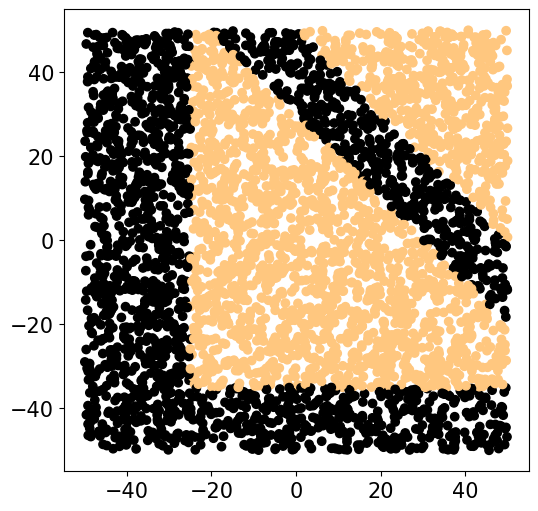

In [3]:
B = 100
TYPE = 1
N_tot = 10000
N = 4000

generate_data_file(n=N_tot, b=B, typ=TYPE)
X = np.loadtxt(filename("data", TYPE), delimiter=' ')
Y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
x = X[:N]
y = Y[:N]
L = x.shape[1]

print("First 10 datas:")
for i in range(10):
    print(x[i, :], int(y[i]))

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y);


We divide the data into training and validation set.

In [4]:
perc_train = 0.8
N_train = int(perc_train * N)

# normalize the data
x = x / np.std(x, axis=0)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]

print("Data:", len(x), "\tTrain:", len(x_train), "\tValidation:", len(x_valid))

Data: 4000 	Train: 3200 	Validation: 800


Here we define a function that builds and compiles the model we want to train, according to the parameters that are passed through the call of the function itself. 

In [5]:
def compile_model(optimizer, activation, dropout_rate, output_dim=2):
    print("opt", optimizer, "activation", activation, "rate", dropout_rate, "out_dim", output_dim)
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='sigmoid'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

Here we implement the GridSearch, trying to minimize the loss with respect to the optimizer, the activation function of the inner layers and the dropout rate.

In [6]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

batch_size = 50
n_epochs = 10
model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)

optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
activations = ['relu', 'sigmoid', 'softmax', 'selu']
dropout_rates = [0, 0.01, 0.1]
param_grid = {"optimizer": optimizer, "activation": activations, "dropout_rate": dropout_rates}

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

y_train_cat = keras.utils.to_categorical(y_train, 2)
grid_result = grid.fit(x_train, y_train_cat)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_9988\1766461357.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)


opt Nadam activation selu rate 0 out_dim 2
Epoch 1/10
64/64 - 2s - loss: 0.6049 - accuracy: 0.6519 - 2s/epoch - 26ms/step
Epoch 2/10
64/64 - 0s - loss: 0.5595 - accuracy: 0.7175 - 104ms/epoch - 2ms/step
Epoch 3/10
64/64 - 0s - loss: 0.5425 - accuracy: 0.7506 - 104ms/epoch - 2ms/step
Epoch 4/10
64/64 - 0s - loss: 0.5293 - accuracy: 0.7713 - 100ms/epoch - 2ms/step
Epoch 5/10
64/64 - 0s - loss: 0.5198 - accuracy: 0.7703 - 96ms/epoch - 2ms/step
Epoch 6/10
64/64 - 0s - loss: 0.5078 - accuracy: 0.7812 - 100ms/epoch - 2ms/step
Epoch 7/10
64/64 - 0s - loss: 0.4956 - accuracy: 0.7859 - 101ms/epoch - 2ms/step
Epoch 8/10
64/64 - 0s - loss: 0.4809 - accuracy: 0.7972 - 99ms/epoch - 2ms/step
Epoch 9/10
64/64 - 0s - loss: 0.4629 - accuracy: 0.8069 - 101ms/epoch - 2ms/step
Epoch 10/10
64/64 - 0s - loss: 0.4394 - accuracy: 0.8153 - 102ms/epoch - 2ms/step
Best: 0.827500 using {'activation': 'selu', 'dropout_rate': 0, 'optimizer': 'Nadam'}
0.638125 (0.045281) with: {'activation': 'relu', 'dropout_rate': 

Here we create a dictionary with the best parameters obtained after the GridSearch. This dictionary is fed to the aforementioned function compile_model that returns the object that then can be fit to the training data and evaluated through the validation data.

In [7]:
best_parameters = {"optimizer": "Nadam", "dropout_rate": 0., "activation": "selu"}
best_param_model = compile_model(activation=best_parameters["activation"], dropout_rate=best_parameters["dropout_rate"], optimizer=best_parameters["optimizer"])

y_valid_cat = keras.utils.to_categorical(y_valid, 2)
best_param_hist=best_param_model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=400,
          verbose=1,
          validation_data=(x_valid, y_valid_cat))

opt Nadam activation selu rate 0.0 out_dim 2
Epoch 1/400
64/64 [==============================] - 2s 7ms/step - loss: 0.6283 - accuracy: 0.6628 - val_loss: 0.5862 - val_accuracy: 0.6825
Epoch 2/400
64/64 [==============================] - 0s 3ms/step - loss: 0.5660 - accuracy: 0.7150 - val_loss: 0.5539 - val_accuracy: 0.7075
Epoch 3/400
64/64 [==============================] - 0s 3ms/step - loss: 0.5392 - accuracy: 0.7328 - val_loss: 0.5211 - val_accuracy: 0.7450
Epoch 4/400
64/64 [==============================] - 0s 3ms/step - loss: 0.5132 - accuracy: 0.7534 - val_loss: 0.4992 - val_accuracy: 0.7738
Epoch 5/400
64/64 [==============================] - 0s 3ms/step - loss: 0.4915 - accuracy: 0.7666 - val_loss: 0.4690 - val_accuracy: 0.7837
Epoch 6/400
64/64 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7763 - val_loss: 0.4524 - val_accuracy: 0.7862
Epoch 7/400
64/64 [==============================] - 0s 2ms/step - loss: 0.4531 - accuracy: 0.7837 - val_loss

Here we plot the accuracy and the loss curves of our model as functions of the specified number of epochs used for the training.

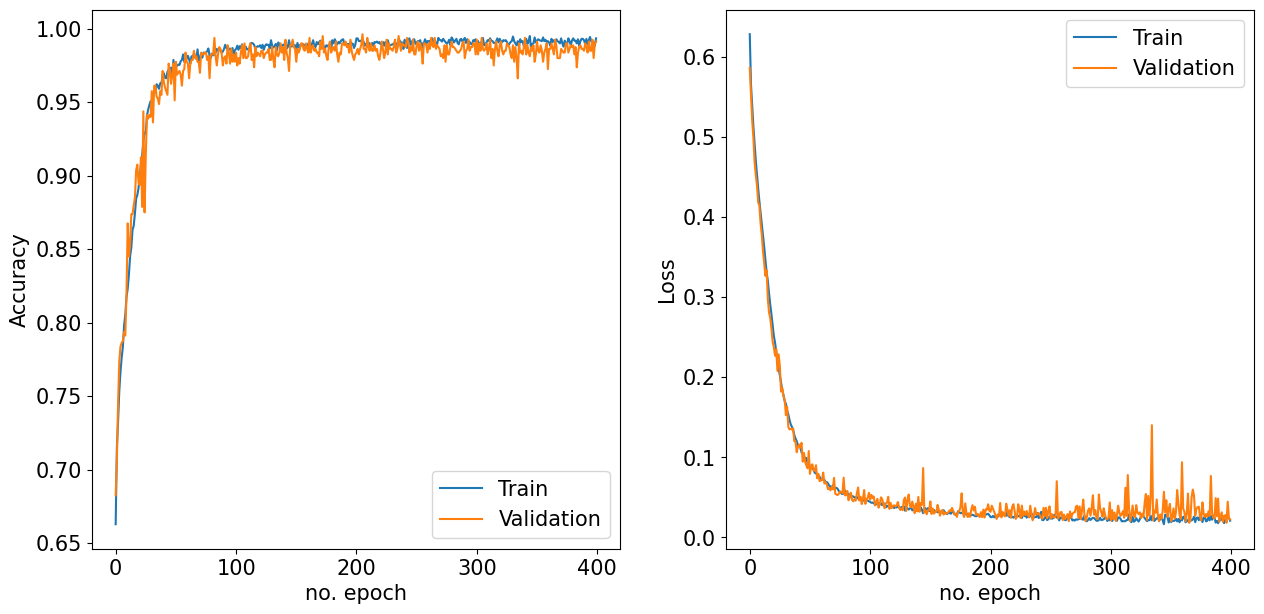

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(best_param_hist.history['accuracy'], label='Train')
ax[0].plot(best_param_hist.history['val_accuracy'], label='Validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[1].plot(best_param_hist.history['loss'], label='Train')
ax[1].plot(best_param_hist.history['val_loss'], label='Validation')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('no. epoch')
ax[1].legend();

### Request no. 2

2.A Here we create an array of percentages between 0.1 and 1 that define a fraction of the 4000 data points used to train the NN in the previous request. Then we cycle with a for loop and we fit the model previously obtained through the GridSearch to all the specified fractions of the data, in order to see how the performance of the NN varies. 

In [9]:
total_data_ratios = np.linspace(0.1, 1, 7)
total_data_N = np.round(len(x) * total_data_ratios).astype(int)

train_accs_histo_dim = np.empty((len(total_data_ratios), 200))
valid_accs_histo_dim = np.empty((len(total_data_ratios), 200))
train_loss_histo_dim = np.empty((len(total_data_ratios), 200))
valid_loss_histo_dim = np.empty((len(total_data_ratios), 200))

for i, N in enumerate(total_data_N):
    perm = np.random.permutation(len(x))
    x, y = x[perm], y[perm]
    x_cut, y_cut = x[0:N], y[0:N]
    N_train = int(perc_train * N)
    x_train, y_train = x_cut[0:N_train], y_cut[0:N_train]
    y_train_cat = keras.utils.to_categorical(y_train, 2)
    x_valid, y_valid = x_cut[N_train:], y_cut[N_train:]
    y_valid_cat = keras.utils.to_categorical(y_valid, 2)

    model = compile_model(**best_parameters)
    fit = model.fit(x_train, y_train_cat, epochs=200, batch_size=50, validation_data=(x_valid, y_valid_cat), verbose=1)
    train_accs_histo_dim[i] = fit.history['accuracy']
    valid_accs_histo_dim[i] = fit.history['val_accuracy']
    train_loss_histo_dim[i] = fit.history['loss']
    valid_loss_histo_dim[i] = fit.history['val_loss']

    print(fit.history)
    print("N:", N, "validation accuracy:", fit.history['val_accuracy'])


opt Nadam activation selu rate 0.0 out_dim 2
Epoch 1/200
7/7 [==============================] - 2s 48ms/step - loss: 1.0270 - accuracy: 0.3656 - val_loss: 0.8271 - val_accuracy: 0.4500
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.8040 - accuracy: 0.3531 - val_loss: 0.7047 - val_accuracy: 0.5250
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.6720 - accuracy: 0.5969 - val_loss: 0.6583 - val_accuracy: 0.6125
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.6165 - accuracy: 0.6906 - val_loss: 0.6509 - val_accuracy: 0.6125
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.5962 - accuracy: 0.6969 - val_loss: 0.6545 - val_accuracy: 0.6125
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 0.5913 - accuracy: 0.6906 - val_loss: 0.6550 - val_accuracy: 0.6250
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 0.5837 - accuracy: 0.7000 - val_loss: 0.6465 - va

We plot as an example the accuracy and loss curves corresponding to different amounts of training data, in order to visualize the difference of the performance. It is possible to see, for example, that the accuracy curve rises and tends to saturate to 1 more quickly as the amount of data increases. In the second row of plots, instead, we show how the mean value of the last 10 epochs of the network training accuracy values varies with respect to the number of considered training data points. As we expected, this average displays an increasing trend as the number of samples increases. 

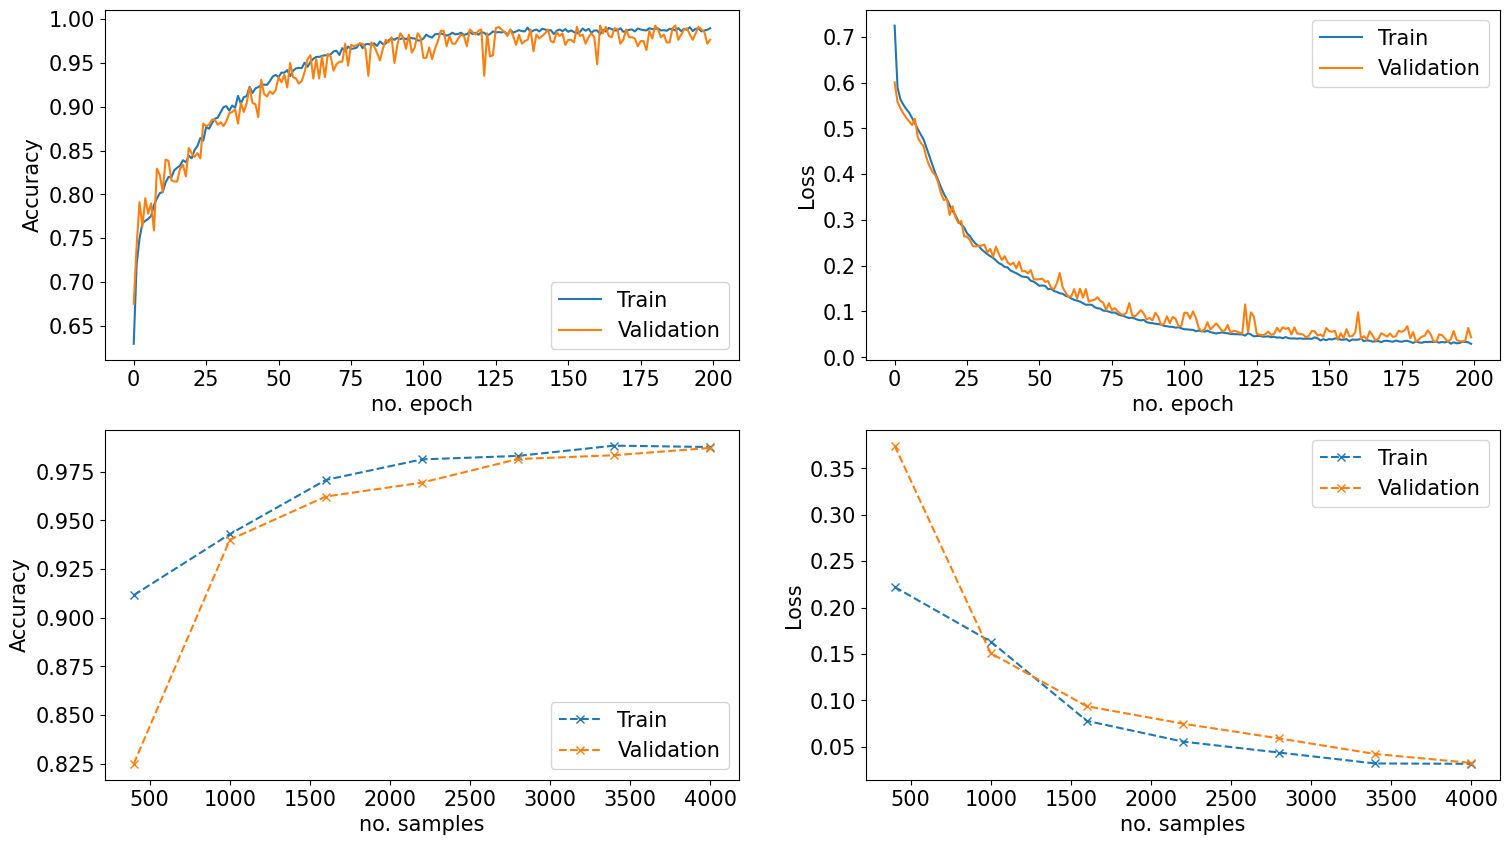

In [10]:
fig, ax = plt.subplots(2,2, figsize=(18,10))
num_data = 5
ax[0,0].plot(train_accs_histo_dim[num_data], label='Train')
ax[0,0].plot(valid_accs_histo_dim[num_data], label='Validation')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('no. epoch')
ax[0,0].legend()
ax[0,1].plot(train_loss_histo_dim[num_data], label='Train')
ax[0,1].plot(valid_loss_histo_dim[num_data], label='Validation')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('no. epoch')
ax[0,1].legend()
ax[1,0].plot(total_data_N, np.mean(train_accs_histo_dim[:,-10:],axis=1), 'x--', label='Train')
ax[1,0].plot(total_data_N, np.mean(valid_accs_histo_dim[:,-10:],axis=1), 'x--', label='Validation')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_xlabel('no. samples')
ax[1,0].legend()
ax[1,1].plot(total_data_N, np.mean(train_loss_histo_dim[:,-10:],axis=1), 'x--', label='Train')
ax[1,1].plot(total_data_N, np.mean(valid_loss_histo_dim[:,-10:],axis=1), 'x--', label='Validation')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('no. samples')
ax[1,1].legend();

2.B Now we perform the same evaluations as just before but considering more samples instead of less.

In [11]:
x = X
y = Y

x = x / np.std(x, axis=0)

total_data_N = np.round(len(x) * np.linspace(0.4, 1, 6)).astype(int)

train_accs_histo_aum = np.empty((len(total_data_N), 200))
valid_accs_histo_aum = np.empty((len(total_data_N), 200))
train_loss_histo_aum = np.empty((len(total_data_N), 200))
valid_loss_histo_aum = np.empty((len(total_data_N), 200))


for i, N in enumerate(total_data_N):
    perm = np.random.permutation(len(x))
    x, y = x[perm], y[perm]
    x_cut, y_cut = x[0:N], y[0:N]
    N_train = int(perc_train * N)
    x_train, y_train = x_cut[0:N_train], y_cut[0:N_train]
    y_train_cat = keras.utils.to_categorical(y_train, 2)
    x_valid, y_valid = x_cut[N_train:], y_cut[N_train:]
    y_valid_cat = keras.utils.to_categorical(y_valid, 2)

    model = compile_model(**best_parameters)
    fit = model.fit(x_train, y_train_cat, epochs=200, batch_size=50, validation_data=(x_valid, y_valid_cat), verbose=1)
    train_accs_histo_aum[i] = fit.history['accuracy']
    valid_accs_histo_aum[i] = fit.history['val_accuracy']
    train_loss_histo_aum[i] = fit.history['loss']
    valid_loss_histo_aum[i] = fit.history['val_loss']

    print(fit.history)
    print("N:", N, "validation accuracy:", fit.history['val_accuracy'])

opt Nadam activation selu rate 0.0 out_dim 2
Epoch 1/200
64/64 [==============================] - 2s 6ms/step - loss: 0.6083 - accuracy: 0.6631 - val_loss: 0.5834 - val_accuracy: 0.7437
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5545 - accuracy: 0.7303 - val_loss: 0.5557 - val_accuracy: 0.7487
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5201 - accuracy: 0.7616 - val_loss: 0.5254 - val_accuracy: 0.7450
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4904 - accuracy: 0.7831 - val_loss: 0.5036 - val_accuracy: 0.7825
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.7969 - val_loss: 0.4712 - val_accuracy: 0.8012
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8075 - val_loss: 0.4415 - val_accuracy: 0.8150
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4090 - accuracy: 0.8250 - val_loss

Here we report the same plots as before. Notice that the lower plots show that the performance of the NN becomes better as more data is fed into it, as one should expect to see. 

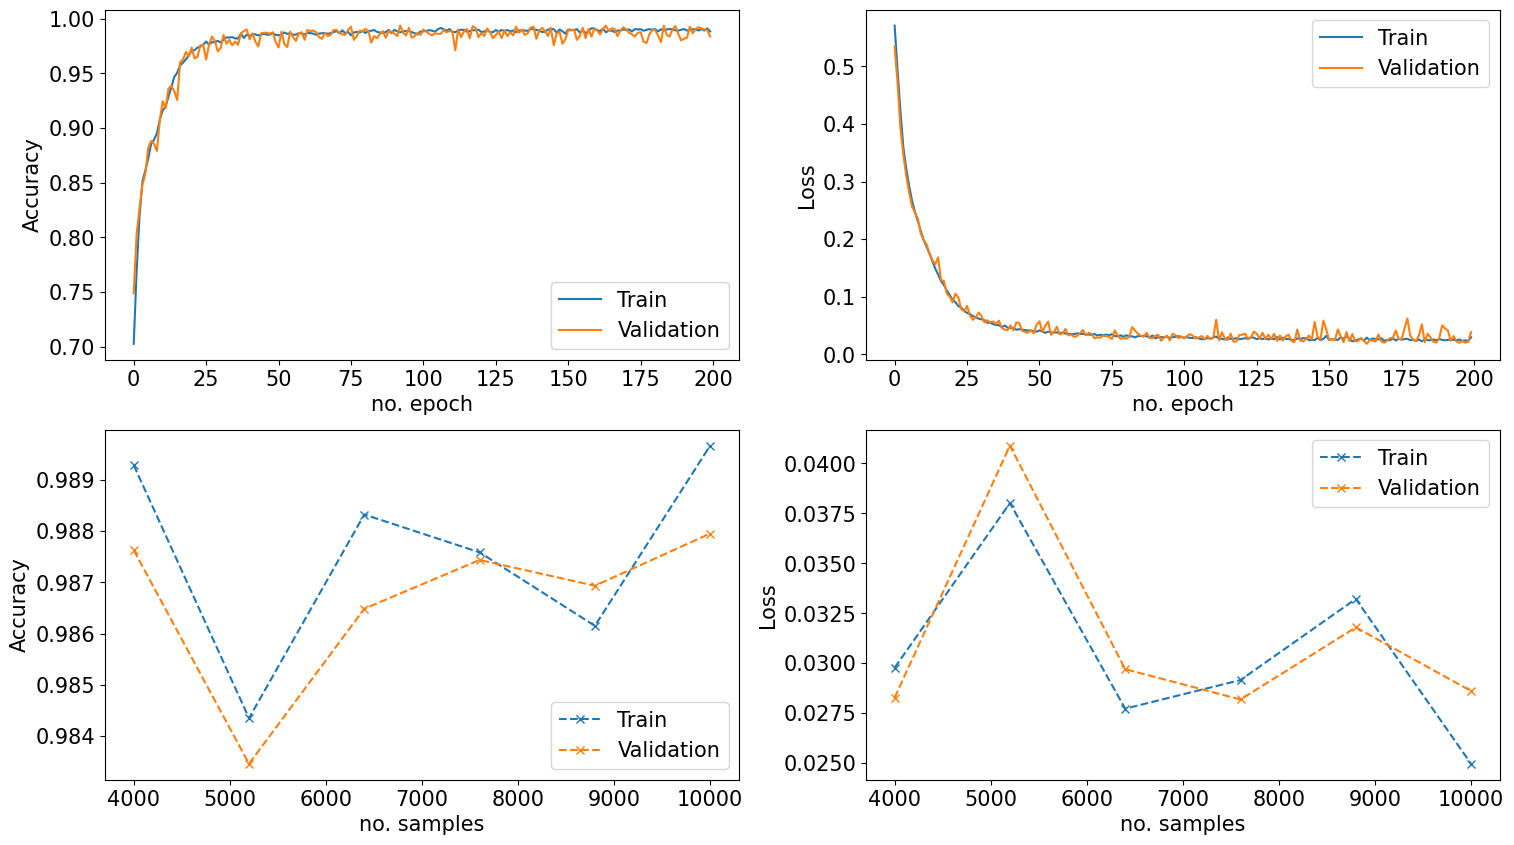

In [12]:
fig, ax = plt.subplots(2,2, figsize=(18,10))
num_data = 5
ax[0,0].plot(train_accs_histo_aum[num_data], label='Train')
ax[0,0].plot(valid_accs_histo_aum[num_data], label='Validation')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('no. epoch')
ax[0,0].legend()
ax[0,1].plot(train_loss_histo_aum[num_data], label='Train')
ax[0,1].plot(valid_loss_histo_aum[num_data], label='Validation')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('no. epoch')
ax[0,1].legend()
ax[1,0].plot(total_data_N, np.mean(train_accs_histo_aum[:,-10:],axis=1), 'x--', label='Train')
ax[1,0].plot(total_data_N, np.mean(valid_accs_histo_aum[:,-10:],axis=1), 'x--', label='Validation')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_xlabel('no. samples')
ax[1,0].legend()
ax[1,1].plot(total_data_N, np.mean(train_loss_histo_aum[:,-10:],axis=1), 'x--', label='Train')
ax[1,1].plot(total_data_N, np.mean(valid_loss_histo_aum[:,-10:],axis=1), 'x--', label='Validation')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('no. samples')
ax[1,1].legend();

2.C Now we consider again 4000 training samples but we introduce a slight argumentation of the data. As random shift we choose a gaussian fluctuation with $\mu = 0$ and $\sigma=0.1$ both on the x and the y coordinates. We think that this choice for the shift is good to simulate a "blur" in proximity of the borders that divide the black and yellow areas visible in the figure below. As a matter of fact, in some real-world problems it is reasonable to think that data do not come from an underlying distribution with very sharp edges that divide the two kind of labels, as shown in the analogous image in Request no. 1, so argumenting the trainin data in this way could strengthen the performance of our network in the case we wanted to test it with a real-world dataset. Moreover argumentation is performed only on training samples (and not validation samples) because of the fact that they are fed into the network, so it is important that they display the criticity or the peculiarity that we expect out NN to face when running in future. Validation samples instead are used to quantify the performance of the network, so we expect them to intrinsically embed the variability that fresh data usually show. 

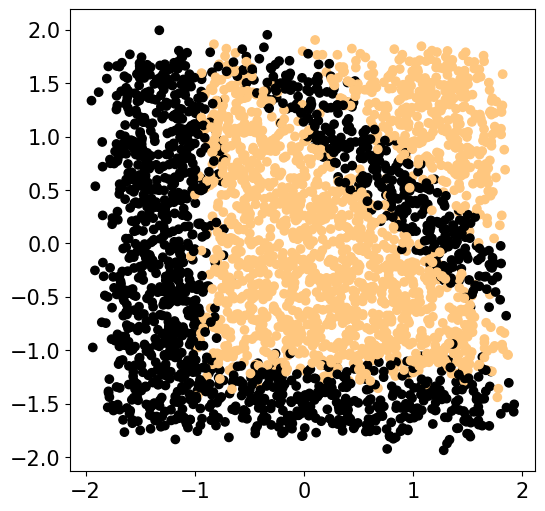

In [13]:
N = 4000
x, y = X[:N], Y[:N]

perc_train = 0.8
N_train = int(perc_train * N)

x = x / np.std(x, axis=0)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]

x_train = x_train + np.random.normal(loc=0, scale=.1, size=(N_train,2)) #training data argumentation

plt.figure(figsize=(6, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train);

Here the argumented data is fed to the NN described by the model obtained following the previous GridSearch.

In [14]:
y_train_cat = keras.utils.to_categorical(y_train, 2)
y_valid_cat = keras.utils.to_categorical(y_valid, 2)
best_param_hist=best_param_model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=400,
          verbose=1,
          validation_data=(x_valid, y_valid_cat))

Epoch 1/400
64/64 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.9219 - val_loss: 0.1010 - val_accuracy: 0.9688
Epoch 2/400
64/64 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.9187 - val_loss: 0.0322 - val_accuracy: 0.9837
Epoch 3/400
64/64 [==============================] - 0s 3ms/step - loss: 0.4132 - accuracy: 0.9231 - val_loss: 0.0664 - val_accuracy: 0.9700
Epoch 4/400
64/64 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.9212 - val_loss: 0.2496 - val_accuracy: 0.9463
Epoch 5/400
64/64 [==============================] - 0s 3ms/step - loss: 0.3227 - accuracy: 0.9181 - val_loss: 0.0534 - val_accuracy: 0.9725
Epoch 6/400
64/64 [==============================] - 0s 3ms/step - loss: 0.3062 - accuracy: 0.9203 - val_loss: 0.1592 - val_accuracy: 0.9375
Epoch 7/400
64/64 [==============================] - 0s 3ms/step - loss: 0.2778 - accuracy: 0.9206 - val_loss: 0.0735 - val_accuracy: 0.9725
Epoch 8/400
6

By plotting the accuracy and loss curves we notice that the performance of the NN is still reasonabily good, even if the behaviour of the curves is more noisy. This could be an indicator that some parameters of the NN could be chosen in order to make it more resilient to this kind of fluctuations. The fact that the validation accuracy results sistematecally larger than the training one could be explained noticing that validation data has not been argumented so it is possible that the NN is sufficiently trained to perforn very well on less "blurred" data.

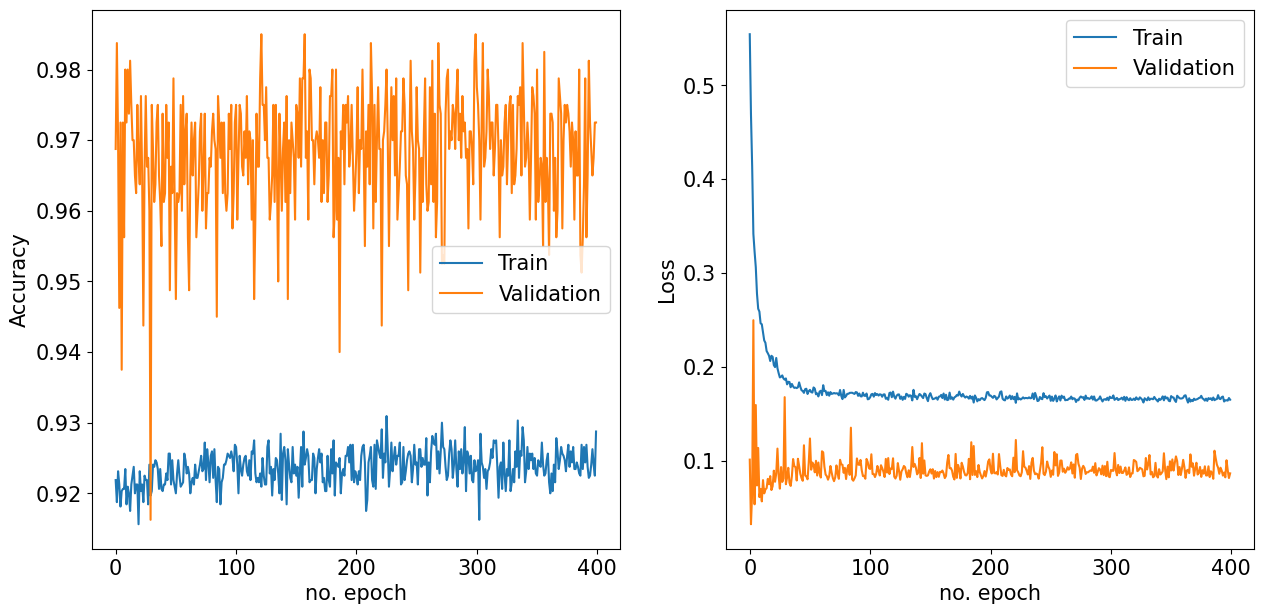

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(best_param_hist.history['accuracy'], label='Train')
ax[0].plot(best_param_hist.history['val_accuracy'], label='Validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[1].plot(best_param_hist.history['loss'], label='Train')
ax[1].plot(best_param_hist.history['val_loss'], label='Validation')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('no. epoch')
ax[1].legend();

### Request no. 3

We changhe the value of TYPE to 2 in order to use the second nonlinear function. Then we perform the same operations (GridSearch and so on) reported for the Request no. 1.

First 10 datas:
[36.29231977 33.68031609] 0
[-43.80680363 -21.81181962] 1
[  3.038604   -45.87363724] 0
[-3.46929577 21.34175032] 1
[-34.32637016 -35.61306129] 1
[ 36.15539366 -15.15186477] 0
[-39.1864607  -10.96164817] 1
[ 42.39517543 -44.9653262 ] 1
[  3.76806085 -27.82484408] 1
[ 24.82068288 -24.78275681] 1


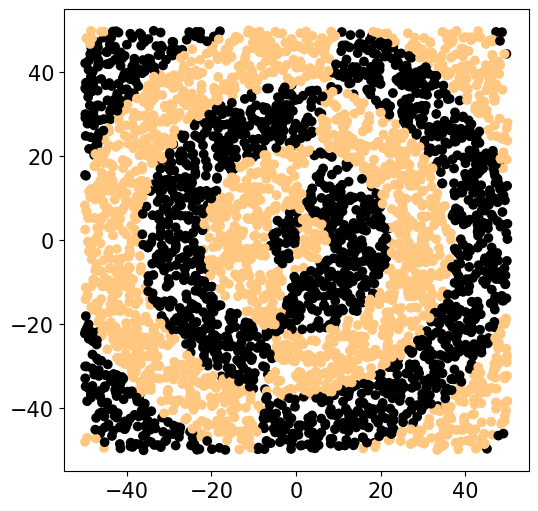

In [16]:
B = 100
TYPE = 2
N_tot = 10000
N = 4000

generate_data_file(n=N_tot, b=B, typ=TYPE)
X = np.loadtxt(filename("data", TYPE), delimiter=' ')
Y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
x = X[:N]
y = Y[:N]
L = x.shape[1]

print("First 10 datas:")
for i in range(10):
    print(x[i, :], int(y[i]))

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y);

In [17]:
perc_train = 0.8
N_train = int(perc_train * N)

# normalize the data
x = x / np.std(x, axis=0)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]

print("Data:", len(x), "\tTrain:", len(x_train), "\tValidation:", len(x_valid))

Data: 4000 	Train: 3200 	Validation: 800


In [18]:
batch_size = 50
n_epochs = 10
model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)

optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
activations = ['relu', 'sigmoid', 'softmax', 'selu']
dropout_rates = [0, 0.01, 0.1]
param_grid = {"optimizer": optimizer, "activation": activations, "dropout_rate": dropout_rates}

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

y_train_cat = keras.utils.to_categorical(y_train, 2)
grid_result = grid.fit(x_train, y_train_cat)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_9988\3491423391.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model, epochs=n_epochs, batch_size=batch_size, verbose=2)


opt RMSprop activation relu rate 0.01 out_dim 2
Epoch 1/10
64/64 - 1s - loss: 0.6901 - accuracy: 0.5447 - 961ms/epoch - 15ms/step
Epoch 2/10
64/64 - 0s - loss: 0.6869 - accuracy: 0.5516 - 93ms/epoch - 1ms/step
Epoch 3/10
64/64 - 0s - loss: 0.6849 - accuracy: 0.5512 - 93ms/epoch - 1ms/step
Epoch 4/10
64/64 - 0s - loss: 0.6834 - accuracy: 0.5525 - 93ms/epoch - 1ms/step
Epoch 5/10
64/64 - 0s - loss: 0.6814 - accuracy: 0.5475 - 95ms/epoch - 1ms/step
Epoch 6/10
64/64 - 0s - loss: 0.6806 - accuracy: 0.5556 - 94ms/epoch - 1ms/step
Epoch 7/10
64/64 - 0s - loss: 0.6799 - accuracy: 0.5537 - 93ms/epoch - 1ms/step
Epoch 8/10
64/64 - 0s - loss: 0.6793 - accuracy: 0.5584 - 92ms/epoch - 1ms/step
Epoch 9/10
64/64 - 0s - loss: 0.6788 - accuracy: 0.5531 - 94ms/epoch - 1ms/step
Epoch 10/10
64/64 - 0s - loss: 0.6785 - accuracy: 0.5584 - 92ms/epoch - 1ms/step
Best: 0.564688 using {'activation': 'relu', 'dropout_rate': 0.01, 'optimizer': 'RMSprop'}
0.507500 (0.013975) with: {'activation': 'relu', 'dropout_r

In [19]:
best_parameters = {"optimizer": "Adam", "dropout_rate": 0., "activation": "selu"}
best_param_model = compile_model(activation=best_parameters["activation"], dropout_rate=best_parameters["dropout_rate"], optimizer=best_parameters["optimizer"])

y_valid_cat = keras.utils.to_categorical(y_valid, 2)
best_param_hist=best_param_model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=400,
          verbose=1,
          validation_data=(x_valid, y_valid_cat))

opt Adam activation selu rate 0.0 out_dim 2
Epoch 1/400
64/64 [==============================] - 1s 6ms/step - loss: 0.7050 - accuracy: 0.5234 - val_loss: 0.6892 - val_accuracy: 0.5525
Epoch 2/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5297 - val_loss: 0.6862 - val_accuracy: 0.5600
Epoch 3/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.5559 - val_loss: 0.6880 - val_accuracy: 0.5362
Epoch 4/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.5353 - val_loss: 0.6847 - val_accuracy: 0.5725
Epoch 5/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.5453 - val_loss: 0.6821 - val_accuracy: 0.5888
Epoch 6/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5603 - val_loss: 0.6836 - val_accuracy: 0.5575
Epoch 7/400
64/64 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.5556 - val_loss:

When plotting the accuracy and loss curve we notice that the GridSearch setup considered for the previous question does not provide results with the same performance as before when applied to samples generated by the nonlinear function 2. This may be due to the fact that the complexity expressed by this function requires a minimization with respect to other parameter that we have not considered, or perhaps an entire NN layout redesign could be needed (i.e. a new arrangement of layers and neurons).

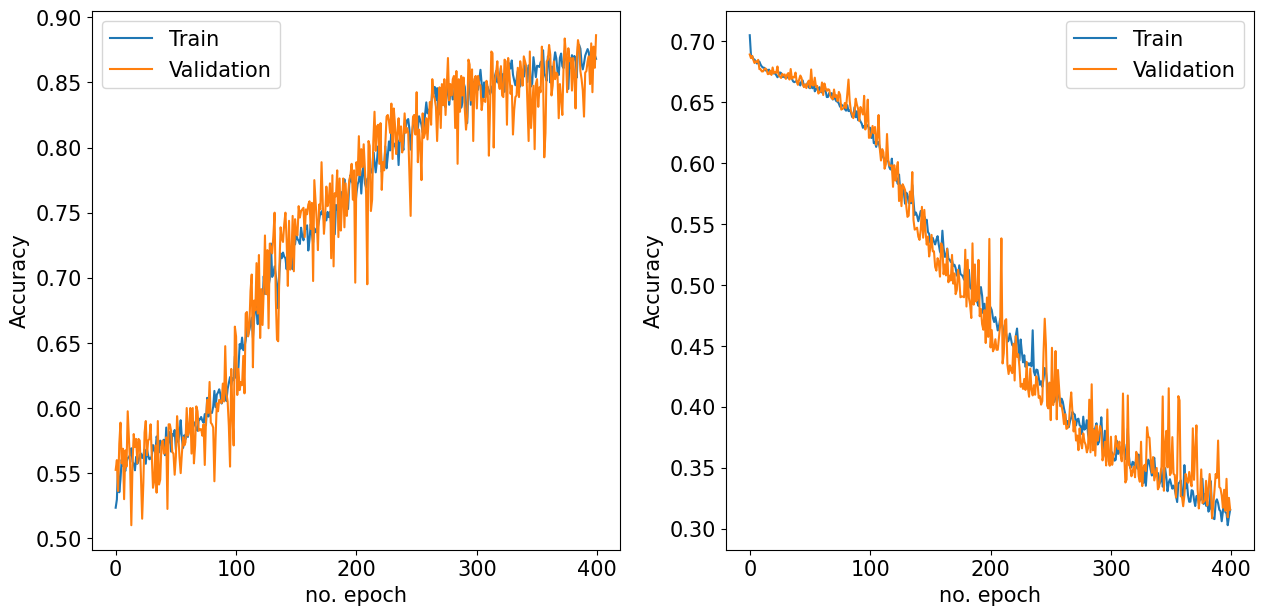

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(best_param_hist.history['accuracy'], label='Train')
ax[0].plot(best_param_hist.history['val_accuracy'], label='Validation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[1].plot(best_param_hist.history['loss'], label='Train')
ax[1].plot(best_param_hist.history['val_loss'], label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('no. epoch')
ax[1].legend();